<a href="https://colab.research.google.com/github/samanehPahlavani/MscFraudDetection/blob/main/EnsembleBestModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive For Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librarries

In [10]:
####Libraries Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

%matplotlib inline
import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [12]:
from sklearn.linear_model import LogisticRegression # for Logistic Regression Algorithm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [13]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVR

In [14]:
from sklearn import metrics # for checking the model accuracy

In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
!pip install pandas_ml

In [17]:
# Import the necessary libraries
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


# Functions Def

In [18]:
def LoadData(data):
  warnings.filterwarnings('ignore')
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  df = pd.read_csv(os.path.join("/content/drive/MyDrive/EtherFirstDataSet/", data+".csv"))
  return df
#Load datas
def preprocessing():

  df1 = LoadData(str(1))
  df2 = LoadData(str(2))

  df1_fillna = df1.copy()
  df2_fillna = df2.copy()

  #Drop Most None Related Value Features
  df1_fillna.drop(["ERC20_uniq_rec_token_name","ERC20_uniq_sent_token_name","ERC20_avg_val_sent","ERC20_max_val_sent","ERC20_min_val_sent","ERC20_avg_val_rec","ERC20_max_val_rec","ERC20_min_val_rec","ERC20_uniq_rec_contract_addr","ERC20_uniq_sent_addr_1","ERC20_uniq_sent_addr","ERC20_total_Ether_sent_contract","ERC20_total_ether_sent","ERC20_total_Ether_received","ERC20_most_rec_token_type","ERC20_most_sent_token_type"], axis=1, inplace=True)
  df1_fillna.drop(["ERC20_uniq_rec_addr","Total_ERC20_tnxs","Time_Diff_between_first_and_last_Mins","total_ether_sent_contracts"], axis=1, inplace=True)
  df2_fillna.drop(["minTimeBetweenSentTnx","maxTimeBetweenSentTnx","minTimeBetweenRecTnx","maxTimeBetweenRecTnx","lifetime","activityDays","dailyMax","ratioRecSent","ratioSentTotal","ratioRecTotal","giniSent","giniRec","txFreq","stdBalanceEth"], axis=1, inplace=True)

  #Rename Columns
  selected_columns = ["address","flag","avgTimeBetweenRecTnx","avgTimeBetweenSentTnx","sentTransactions" ,"receivedTransactions", "createdContracts" ,"Average_of_numUniqRecAddress" ,"Average_of_numUniqSentAddress"
  ,"minValReceived"
  ,"maxValReceived"
  ,"avgValReceived"
  , "minValSent"
  , "maxValSent"
  ,"avgValSent"
  ,"totalTransactions"
  ,"totalEtherSent"
  ,"totalEtherReceived"
  ,"totalEtherBalance"    ]

  df2_fillna = df2[selected_columns].copy()

  df2_fillna.columns = ["Address"
  ,"FLAG"
  ,"Avg_min_between_received_tnx"
  ,"Avg_min_between_sent_tnx"
  ,"Sent_tnx"
  ,"Received_Tnx"
  ,"Number_of_Created_Contracts"
  ,"Average_of_Unique_Received_From_Addresses"
  ,"Average_of_Unique_Sent_To_Addresses"
  ,"min_value_received"
  ,"max_value_received "
  ,"avg_val_received"
  ,"min_val_sent"
  ,"max_val_sent"
  ,"avg_val_sent"
  ,"total_transactions_including_tnx_to_create_contract"
  ,"total_Ether_sent"
  ,"total_ether_received"
  ,"total_ether_balance"
  ]

  merged_df = pd.merge(df1_fillna, df2_fillna, how='outer')
  df_filtered = merged_df.drop_duplicates(subset='Address', keep='first')
  return df_filtered



In [19]:
def scaled(data):
  # Convert categorical 'FLAG' to numeric
  label_encoder = LabelEncoder()
  data['FLAG'] = label_encoder.fit_transform(data['FLAG'])

  # Splitting the data into features (X) and labels (y)
  X =  data.drop(['FLAG'], axis=1)
  y = data['FLAG']

  # Standardize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  #X_scaled['FLAG'] = y


  return X_scaled,y

In [20]:
def undersampling(data, target_column):
    # Separate features and target variable
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Apply undersampling
    undersampler = RandomUnderSampler()
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # Get indices of selected samples
    selected_indices = undersampler.sample_indices_

    # Get indices of unselected samples
    unselected_indices = np.setdiff1d(np.arange(len(X)), selected_indices)

    # Extract unselected samples
    X_unselected = X.iloc[unselected_indices]
    y_unselected = y.iloc[unselected_indices]

    # Combine unselected data into a DataFrame
    unselected_data = pd.concat([X_unselected, y_unselected], axis=1)
    resampled = pd.concat([X_resampled, y_resampled], axis=1)
    return resampled, unselected_data

In [21]:
def oversampling(data, target_column):
    # Separate features and target variable
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Apply oversampling
    oversampler = RandomOverSampler()
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # Get indices of selected samples
    selected_indices = oversampler.sample_indices_

    # Get indices of unselected samples
    unselected_indices = np.setdiff1d(np.arange(len(X)), selected_indices)

    # Extract unselected samples
    X_unselected = X.iloc[unselected_indices]
    y_unselected = y.iloc[unselected_indices]

    # Combine unselected data into a DataFrame
    unselected_data = pd.concat([X_unselected, y_unselected], axis=1)
    resampled = pd.concat([X_resampled, y_resampled], axis=1)

    return resampled, unselected_data

In [22]:
def smote(data, target_column):
    # Separate features and target variable
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Apply SMOTE
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Combine resampled data into a DataFrame
    resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=target_column)], axis=1)
    return resampled_data,''

In [23]:
def ballanced(data,type="O"):

  if type=="U":
    resampled, unselected_data = undersampling(data, 'FLAG')
  elif type=="S":
    resampled, unselected_data  = smote(data, 'FLAG')
  elif type=="O":
    resampled, unselected_data = oversampling(data, 'FLAG')


  return resampled, unselected_data


#**Preprocessing **

In [24]:
df_filtered = preprocessing()
df_filtered = df_filtered.drop(['Address'], axis=1)

**Imballanced Dataset**

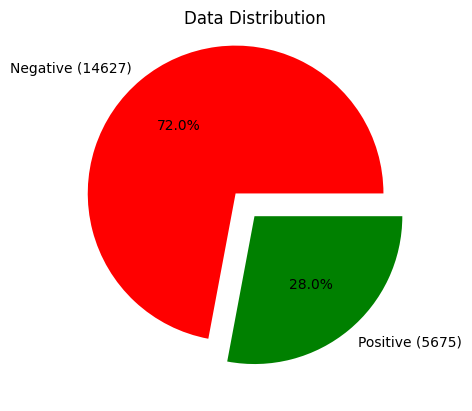

In [25]:
df = df_filtered
positive_sample = df[(df["FLAG"]==1)]
negative_sample = df[(df["FLAG"]==0)]
dist = df["FLAG"].value_counts()

_ = plt.pie(dist, labels = ["Negative ({0})".format(len(negative_sample)), "Positive ({0})".format(len(positive_sample))], colors = ["r", "g"], explode=[0.2, 0], autopct='%1.1f%%')
_ = plt.title("Data Distribution")

In [26]:
#df_filtered = np.array(df_filtered)
df_filtered.shape

(20302, 18)

In [27]:
resampledOver, unselected_Over = ballanced(df_filtered,"O")
resampledOver.shape

(29254, 18)

In [28]:
resampledUnder, unselected_Under = ballanced(df_filtered,"U")
resampledUnder.shape

(11350, 18)

In [29]:
resampledSmote, unselected_Smote = ballanced(df_filtered,"S")
resampledSmote.shape

(29254, 18)

In [30]:
resampledSmote.head(10)

,Avg_min_between_received_tnx,Avg_min_between_sent_tnx,Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Average_of_Unique_Received_From_Addresses,Average_of_Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_including_tnx_to_create_contract,total_Ether_sent,total_ether_received,total_ether_balance,FLAG
0,1093.71,844.26,721,89,0,40,118,0.000000,45.806785,6.589513,0.000000,31.220000,1.200681,810,865.691093,586.466675,-279.224419,0
1,2958.44,12709.07,94,8,0,5,14,0.000000,2.613269,0.385685,0.000000,1.800000,0.032844,102,3.087297,3.085478,-0.001819,0
2,2434.02,246194.54,2,10,0,10,2,0.113119,1.165453,0.358906,0.050000,3.538616,1.794308,12,3.588616,3.589057,0.000441,0
3,15785.09,10219.60,25,9,0,7,13,0.000000,500.000000,99.488840,0.000000,450.000000,70.001834,34,1750.045862,895.399559,-854.646303,0
4,10707.77,36.61,4598,20,1,7,19,0.000000,12.802411,2.671095,0.000000,9.000000,0.022688,4619,104.318883,53.421897,-50.896986,0
5,375.48,9900.12,2,3,0,2,1,0.724148,4.813776,3.234908,4.166800,5.536916,4.851858,5,9.703716,9.704724,0.001008,0
6,629.44,69.46,25,11,0,9,20,0.049000,2.650000,1.098115,0.009457,4.284785,0.482496,36,12.062394,12.079266,0.016872,0
7,176.84,1497.39,213,5,0,3,3,0.118490,2.000000,0.891098,0.000000,0.700000,0.040861,218,8.703392,4.455490,-4.247902,0
8,0.00,0.00,1,1,0,1,1,2.000000,2.000000,2.000000,1.999380,1.999380,1.999380,2,1.999380,2.000000,0.000620,0
9,3336.01,2570.59,8,3,0,2,4,0.100000,40.000000,16.700000,0.100000,40.000000,18.634625,11,149.077000,50.100000,-98.977000,0


#***Rescaling***

In [31]:
X_reshaped,y_reshaped = scaled(df_filtered)
X_reshaped.shape

(20302, 17)

In [32]:
X_reshapedO,y_reshapedO = scaled(resampledOver)
X_reshapedO.shape

(29254, 17)

In [33]:
X_reshapedS,y_reshapedS = scaled(resampledSmote)
X_reshapedS.shape

(29254, 17)

In [34]:
X_reshapedU,y_reshapedU= scaled(resampledUnder)
X_reshapedU.shape

(11350, 17)

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test =  train_test_split(X_reshaped, df_filtered['FLAG'], test_size=0.1, random_state=42)

In [36]:
X_trainO, X_testO, y_trainO, y_testO =  train_test_split(X_reshapedO, y_reshapedO, test_size=0.1, random_state=42)

In [37]:
X_trainU, X_testU, y_trainU, y_testU =  train_test_split(X_reshapedS, y_reshapedS, test_size=0.1, random_state=42)

In [38]:
X_trainS, X_testS, y_trainS, y_testS =  train_test_split(X_reshapedU, y_reshapedU, test_size=0.1, random_state=42)

In [39]:
# Define the list of training/testing sets
training_sets = [(X_train, y_train), (X_trainO, y_trainO), (X_trainU, y_trainU), (X_trainS, y_trainS)]
testing_sets = [(X_test, y_test), (X_testO, y_testO), (X_testU, y_testU), (X_testS, y_testS)]

# #**Models**

# #**Ensemble1**
ExrtraTrees

RF

XGBOOST



In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, roc_auc_score

import time

In [41]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import KFold


In [42]:
kf = KFold(n_splits=10, random_state = 42, shuffle=True)
fld = 1
i = 1
X = np.concatenate([X_trainO, X_testO], axis=0)
y = np.concatenate([y_trainO, y_testO], axis=0)


In [43]:
X_train, X_POtest, y_train, y_POtest = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:

results = {}


In [45]:
X_df = pd.DataFrame(X_train)
y_df = pd.DataFrame(y_train)

In [46]:
ExtraTrees = ExtraTreesClassifier(random_state=42)
RF = RandomForestClassifier(random_state=42)
XGB = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [47]:
from sklearn.ensemble import VotingClassifier
import time

In [48]:
voting_clf = VotingClassifier(estimators=[
    ('extra_trees', ExtraTrees),
    ('XGB', XGB)],
    voting='soft')
fld=1

In [49]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, roc_auc_score


In [50]:
for train_index, test_index in kf.split(X_train):

    TotalTraining_time = 0
    TotalInference_Time = 0

    X_trainV, X_testV = X_df.iloc[train_index], X_df.iloc[test_index]
    y_trainV, y_testV = y_df.iloc[train_index, 0], y_df.iloc[test_index, 0]  # Convert to Series if y_df is single column DataFrame

    start_time = time.time()
    RF.fit(X_trainV, y_trainV)
    TotalTraining_time += time.time() - start_time

    # Use argsort directly on feature_importances_, then use .iloc for proper indexing
    important_features = np.argsort(RF.feature_importances_)[::-1]

    start_time = time.time()
    # Adjust indexing for pandas DataFrame
    voting_clf.fit(X_trainV.iloc[:, important_features[:]], y_trainV)  # Assuming you want to select top 10 features
    TotalTraining_time += time.time() - start_time

    start_time = time.time()
    # Adjust indexing for pandas DataFrame in prediction as well
    V_predictions = voting_clf.predict(X_testV.iloc[:, important_features[:]])
    TotalInference_Time += time.time() - start_time

    accuracy = accuracy_score(y_testV, V_predictions)
    precision = precision_score(y_testV, V_predictions)
    recall = recall_score(y_testV, V_predictions)
    f1 = f1_score(y_testV, V_predictions)
    kappa = cohen_kappa_score(y_testV, V_predictions)
    #confusion_matrix = confusion_matrix(y_testV, V_predictions)
    roc_auc = roc_auc_score(y_testV, V_predictions)
    fpr, tpr, thresholds = roc_curve(y_testV, V_predictions)

    results[f'Model_{fld}'] = { 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,'kappa':kappa,'roc_auc':roc_auc
                                      ,'tpr':tpr,'thresholds':thresholds,'Inference_Time':TotalInference_Time,'Training_time':TotalTraining_time}


    print(f'Metrics for Fold {fld}:')
    print(f"Inference Time: {TotalInference_Time:.4f} seconds")
    print(f"training Time: {TotalTraining_time:.4f} seconds")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"fpr: {fpr}")
    print(f"tpr: {tpr}")
    print(f"thresholds: {thresholds}")
   # print(confusion_matrix)
    print("********************************************************************")

    fld += 1


Metrics for Fold 1:
Inference Time: 0.1525 seconds
training Time: 17.8249 seconds
Accuracy: 0.96
Precision: 0.95
Recall: 0.97
F1-score: 0.96
kappa: 0.92
ROC AUC: 0.96
fpr: [0.         0.05456095 1.        ]
tpr: [0.         0.97174658 1.        ]
thresholds: [2 1 0]
********************************************************************
Metrics for Fold 2:
Inference Time: 0.3175 seconds
training Time: 21.8999 seconds
Accuracy: 0.97
Precision: 0.96
Recall: 0.98
F1-score: 0.97
kappa: 0.93
ROC AUC: 0.97
fpr: [0.         0.04239401 1.        ]
tpr: [0.         0.97627417 1.        ]
thresholds: [2 1 0]
********************************************************************
Metrics for Fold 3:
Inference Time: 0.0923 seconds
training Time: 13.9981 seconds
Accuracy: 0.96
Precision: 0.95
Recall: 0.97
F1-score: 0.96
kappa: 0.92
ROC AUC: 0.96
fpr: [0.         0.04753962 1.        ]
tpr: [0.         0.97110333 1.        ]
thresholds: [2 1 0]
*************************************************************

In [51]:
V_predictions = voting_clf.predict(X_POtest[:, important_features[:]])
accuracy_clf = accuracy_score(y_POtest, V_predictions)
accuracy = accuracy_score(y_POtest, V_predictions)
precision = precision_score(y_POtest, V_predictions)
recall = recall_score(y_POtest, V_predictions)
f1 = f1_score(y_POtest, V_predictions)
kappa = cohen_kappa_score(y_POtest, V_predictions)
roc_auc = roc_auc_score(y_POtest, V_predictions)
fpr, tpr, thresholds = roc_curve(y_POtest, V_predictions)

In [52]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"kappa: {kappa:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print(f"fpr: {fpr}")
print(f"tpr: {tpr}")
print(f"thresholds: {thresholds}")

Accuracy: 0.96
Precision: 0.94
Recall: 0.98
F1-score: 0.96
kappa: 0.92
ROC AUC: 0.96
fpr: [0.         0.06087551 1.        ]
tpr: [0.        0.9795012 1.       ]
thresholds: [2 1 0]


In [53]:
# Initialize lists to store metric values
accuracies = []
precisions = []
recalls = []
f1_scores = []
kappas = []
Inference_Time = []
Training_time = []
roc_auc = []
# Loop over the results dictionary
for model, metrics in results.items():
    accuracies.append(metrics['accuracy'])
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])
    f1_scores.append(metrics['f1'])
    kappas.append(metrics['kappa'])
    Inference_Time.append(metrics['Inference_Time'])
    Training_time.append(metrics['Training_time'])
    roc_auc.append(metrics['roc_auc'])

# Calculate the best, worst, and average values for each metric
best_accuracy = round(max(accuracies), 2)
worst_accuracy = round(min(accuracies), 2)
average_accuracy = round(sum(accuracies) / len(accuracies), 2)


best_precision = round(max(precisions), 2)
worst_precision = round(min(precisions), 2)
average_precision = round(sum(precisions) / len(precisions), 3)

best_recall = round(max(recalls), 2)
worst_recall = round(min(recalls), 2)
average_recall = round(sum(recalls) / len(recalls), 2)

best_f1_score = round(max(f1_scores), 2)
worst_f1_score = round(min(f1_scores), 2)
average_f1_score = round(sum(f1_scores) / len(f1_scores), 2)

best_kappa = round(max(kappas), 2)
worst_kappa = round(min(kappas), 2)
average_kappa = round(sum(kappas) / len(kappas), 2)

best_Inference_Time = round(max(Inference_Time), 5)
worst_Inference_Time = round(min(Inference_Time), 5)
average_Inference_Time = round(sum(Inference_Time) / len(Inference_Time), 5)


best_Training_time = round(max(Training_time), 5)
worst_Training_time = round(min(Training_time), 5)
average_Training_time = round(sum(Training_time) / len(Training_time), 5)

best_roc_auc = round(max(roc_auc), 2)
worst_roc_auc = round(min(roc_auc), 2)
average_roc_auc = round(sum(roc_auc) / len(roc_auc), 2)

# Print the results
print("Best Accuracy:", best_accuracy)
print("Worst Accuracy:", worst_accuracy)
print("Average Accuracy:", average_accuracy)

print("************************************************")


print("Best Precision:", best_precision)
print("Worst Precision:", worst_precision)
print("Average Precision:", average_precision)
print("************************************************")

print("Best Recall:", best_recall)
print("Worst Recall:", worst_recall)
print("Average Recall:", average_recall)
print("************************************************")

print("Best F1 Score:", best_f1_score)
print("Worst F1 Score:", worst_f1_score)
print("Average F1 Score:", average_f1_score)
print("************************************************")

print("Best Kappa:", best_kappa)
print("Worst Kappa:", worst_kappa)
print("Average Kappa:", average_kappa)

print("************************************************")

print("Best Inference_Time:", best_Inference_Time)
print("Worst Inference_Time:", worst_Inference_Time)
print("Average Inference_Time:", average_Inference_Time)
print("************************************************")

print("Best Training_time:", best_Training_time)
print("Worst Training_time:", worst_Training_time)
print("Average Training_time:", average_Training_time)
print("************************************************")

print("Best roc_auc:", best_roc_auc)
print("Worst roc_auc:", worst_roc_auc)
print("Average roc_auc:", average_roc_auc)


Best Accuracy: 0.97
Worst Accuracy: 0.96
Average Accuracy: 0.96
************************************************
Best Precision: 0.96
Worst Precision: 0.94
Average Precision: 0.948
************************************************
Best Recall: 0.98
Worst Recall: 0.97
Average Recall: 0.98
************************************************
Best F1 Score: 0.97
Worst F1 Score: 0.96
Average F1 Score: 0.96
************************************************
Best Kappa: 0.93
Worst Kappa: 0.91
Average Kappa: 0.92
************************************************
Best Inference_Time: 0.31746
Worst Inference_Time: 0.08621
Average Inference_Time: 0.13043
************************************************
Best Training_time: 21.89989
Worst Training_time: 7.99838
Average Training_time: 11.53524
************************************************
Best roc_auc: 0.97
Worst roc_auc: 0.96
Average roc_auc: 0.96
